Causal Model

$$
T \leftarrow f_t(u_t)
$$
$$
Y \leftarrow f_y(T, u_y)
$$

Here, $u_t = $ **Exogenous variables** (set of variables that are not explicitly modeled.) \
Variables included in the model are: **Endogenous Variables**. \
\
$\leftarrow$ is used to denote the nonreversability of causality.

Example:
$$
BusinessSize \leftarrow f_s(u_s)
$$
$$
IsOnSales \leftarrow f_t(BusinessSize, u_t)
$$
$$
AmountSold \leftarrow f_y(IsOnSales,BusinessSize, u_y)
$$

Here, BusinessSize is a common cause to both the treatment IsOnSales and the outcome AmountSold.

Can be understood as: \
$
AmountSold_i = \alpha + \beta_1IsOnSales_i + \beta_2BusinessSize_i + e_i
$

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [32]:
data = pd.read_csv("xmas_sales.csv")
data.head(6)

,store,weeks_to_xmas,avg_week_sales,is_on_sale,weekly_amount_sold
0,1,3,12.98,1,219.60
1,1,2,12.98,1,184.70
2,1,1,12.98,1,145.75
3,1,0,12.98,0,102.45
4,2,3,19.92,0,103.22
5,2,2,19.92,0,53.73


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   store               2000 non-null   int64  
 1   weeks_to_xmas       2000 non-null   int64  
 2   avg_week_sales      2000 non-null   float64
 3   is_on_sale          2000 non-null   int64  
 4   weekly_amount_sold  2000 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 78.3 KB


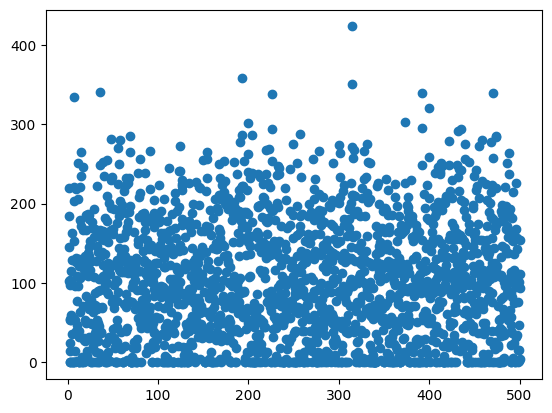

In [4]:
plt.scatter(data['store'], data['weekly_amount_sold'])

In [5]:
# constant for the intercept in the model
data['intercept'] = 1

treatment = 'is_on_sale'
outcome = 'weekly_amount_sold'
covariates = ['intercept', 'weeks_to_xmas', 'avg_week_sales']

In [6]:
# Regression model for ATE estimation
model = sm.OLS(data[outcome], data[[treatment] + covariates]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     weekly_amount_sold   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     993.5
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        11:00:15   Log-Likelihood:                -10566.
No. Observations:                2000   AIC:                         2.114e+04
Df Residuals:                    1996   BIC:                         2.116e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_on_sale        52.0264      2.282     22.

In [7]:
# Extract ATE from the coefficient of 'is_on_sale'
ate = model.params[treatment]
print(f"Estimated ATE: {ate}")

Estimated ATE: 52.02638666379548


In [8]:
# Calculating CATE for a specific group (e.g., stores where weeks_to_xmas is 3)
group_data = data[data['weeks_to_xmas'] == 3]
cate_model = sm.OLS(group_data[outcome], group_data[[treatment] + covariates]).fit()
cate = cate_model.params[treatment]
print(f"Estimated CATE for weeks_to_xmas=3: {cate}")

Estimated CATE for weeks_to_xmas=3: 54.645813448335524


#### ATE from Scratch

In [10]:
# separating treated and untreated groups
treated = data[data[treatment]==1][outcome]
treated[:10]

0     219.60
1     184.70
2     145.75
12    115.38
14     59.95
20     55.79
24    334.23
26    203.68
27    153.11
32    218.92
Name: weekly_amount_sold, dtype: float64

In [11]:

untreated = data[data[treatment]==0][outcome]
untreated[:10]

3     102.45
4     103.22
5      53.73
6      13.84
7       0.00
8      97.02
9      54.72
10     24.60
11      0.00
13     53.70
Name: weekly_amount_sold, dtype: float64

In [12]:
ate_naive = treated.mean() - untreated.mean()
print(f'Naive ATE: {ate_naive}')

Naive ATE: 77.95410476434428


#### ATE with Linear Regression

Including other covariates, their influences on the outcome are accounted for. The coefficient for 'Treatment' represents effect of treatment after adjusting for the covariates.

In [24]:
X = data[[treatment, 'intercept', 'weeks_to_xmas', 'avg_week_sales']]
X[:10]

,is_on_sale,intercept,weeks_to_xmas,avg_week_sales
0,1,1,3,12.98
1,1,1,2,12.98
2,1,1,1,12.98
3,0,1,0,12.98
4,0,1,3,19.92
5,0,1,2,19.92
6,0,1,1,19.92
7,0,1,0,19.92
8,0,1,3,18.54
9,0,1,2,18.54


In [25]:
y = data[outcome]
y[:10]

0    219.60
1    184.70
2    145.75
3    102.45
4    103.22
5     53.73
6     13.84
7      0.00
8     97.02
9     54.72
Name: weekly_amount_sold, dtype: float64

In [26]:
model = LinearRegression().fit(X, y)
ate_adjusted = model.coef_[0]
print(f'ATE Adjusted: {ate_adjusted}')

ATE Adjusted: 52.02638666379434


#### ATE with Dowhy

In [27]:
from dowhy import CausalModel

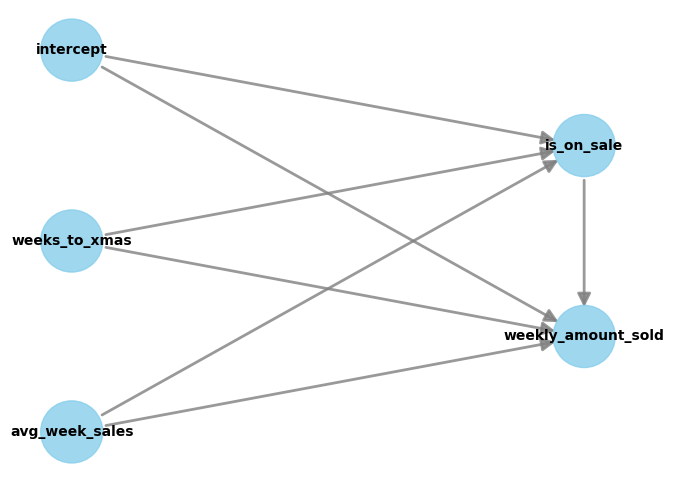

In [28]:
model = CausalModel(
    data=data,
    treatment=treatment,
    outcome=outcome,
    common_causes=covariates
)
model.view_model()

In [29]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                   
────────────(E[weekly_amount_sold|weeks_to_⟨xmas,intercept,⟩_week_sales])
d[isₒₙ ₛₐₗₑ]                                                             
Estimand assumption 1, Unconfoundedness: If U→{is_on_sale} and U→weekly_amount_sold then P(weekly_amount_sold|is_on_sale,weeks_to_xmas,intercept,avg_week_sales,U) = P(weekly_amount_sold|is_on_sale,weeks_to_xmas,intercept,avg_week_sales)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [30]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print(f'Adjusted ATE: {estimate.value}')

Adjusted ATE: 52.02638666379542


D:\After\torch\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
